## Visualization of Robot missions

In [13]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import haversine as hs
from haversine import Unit
from matplotlib.ticker import FormatStrFormatter
import matplotlib.gridspec as gridspec

In [14]:
input_data_folder_base = Path("../results/")
input_data_folder = Path.cwd() / input_data_folder_base
overall_collection_file_name = "overall_collection_2023.p"
key_parameter_file_name = "key_parameter_2023.p"
print(f"Reading raw pandas files from \n    {input_data_folder}")

output_folder_base = Path("../html/")
output_image_folder = output_folder_base / Path("./images/")
print(f"Writing website information to \n    {output_folder_base}")

Reading raw pandas files from 
    /home/sebastian/Nextcloud/Projekte/2021_DAAD_Brasilien/2023/RoBiMo_Trop_DataSet/notebooks/../results
Writing website information to 
    ../html


In [15]:
df_results = pd.read_pickle(input_data_folder / overall_collection_file_name)
df_results.head(3)


,lat_est,lon_est,yaw_est,hdop,nsats,lat_meas,lon_meas,depth,experiment_location,meas_running,...,CO2(ppm),airtemp in(degreeC),humidity in(rH),pressure in(mbar),airtemp out(degreeC),humidity out(rH),pressure out(mbar),PAR(umol m-2s-1),H2O temp(degreeC),position
datetime_AMT,,,,,,,,,,,,,,,,,,,,,
2023-03-11 18:46:18,-3.291846,-60.163836,160.312,0.51,24.0,-3.291846,-60.163836,8.102606,Iranduba,True,...,377.019372,26.637414,98.993146,1008.21385,26.529385,94.207610,1006.39028,0.0,25.232794,2.0
2023-03-11 18:46:19,-3.291846,-60.163836,157.872,0.51,24.0,-3.291846,-60.163836,8.094523,Iranduba,True,...,376.683674,26.637414,98.979412,1008.17570,26.512906,94.210662,1006.39028,0.0,25.310671,2.0
2023-03-11 18:46:20,-3.291846,-60.163835,155.718,0.51,24.0,-3.291846,-60.163835,8.112709,Iranduba,True,...,377.232998,26.641076,98.990094,1008.22911,26.531216,94.215240,1006.45132,0.0,25.316779,2.0


(18585, 21)


/tmp/ipykernel_81891/2661242827.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_vertical_hist = plt.subplot(gs[0])
/tmp/ipykernel_81891/2661242827.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_vertical_hist = plt.subplot(gs[0])
/tmp/ipykernel_81891/2661242827.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_vertical_hist = plt.subplot(gs[0])
/tmp/ipykernel_81891/2661242827.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_vertical_hist = plt.subplot(gs[

(16690, 21)


/tmp/ipykernel_81891/2661242827.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_vertical_hist = plt.subplot(gs[0])
/tmp/ipykernel_81891/2661242827.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_vertical_hist = plt.subplot(gs[0])
/tmp/ipykernel_81891/2661242827.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_vertical_hist = plt.subplot(gs[0])


(20940, 21)


/tmp/ipykernel_81891/2661242827.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_vertical_hist = plt.subplot(gs[0])
/tmp/ipykernel_81891/2661242827.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_vertical_hist = plt.subplot(gs[0])
/tmp/ipykernel_81891/2661242827.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_vertical_hist = plt.subplot(gs[0])
/tmp/ipykernel_81891/2661242827.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_vertical_hist = plt.subplot(gs[

(18459, 21)


/tmp/ipykernel_81891/2661242827.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_vertical_hist = plt.subplot(gs[0])
/tmp/ipykernel_81891/2661242827.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_vertical_hist = plt.subplot(gs[0])
/tmp/ipykernel_81891/2661242827.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_vertical_hist = plt.subplot(gs[0])
/tmp/ipykernel_81891/2661242827.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_vertical_hist = plt.subplot(gs[

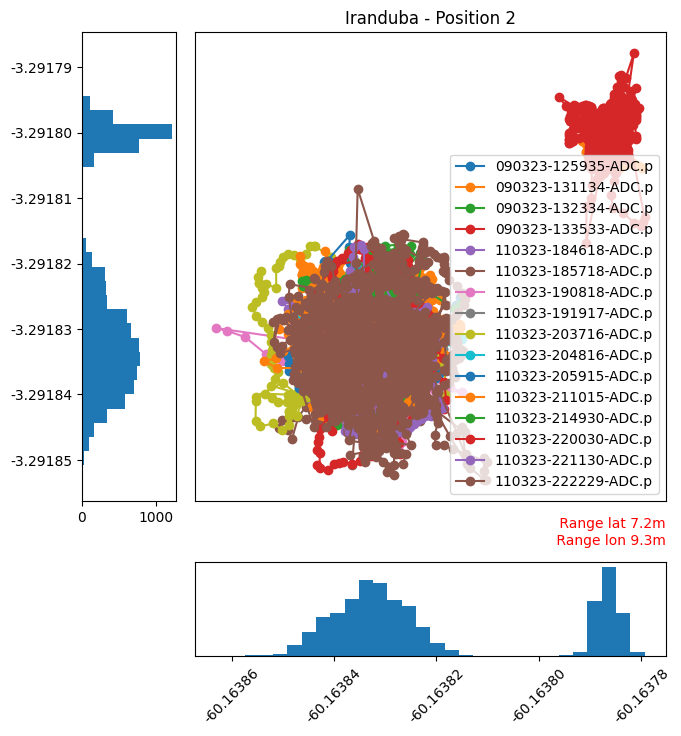

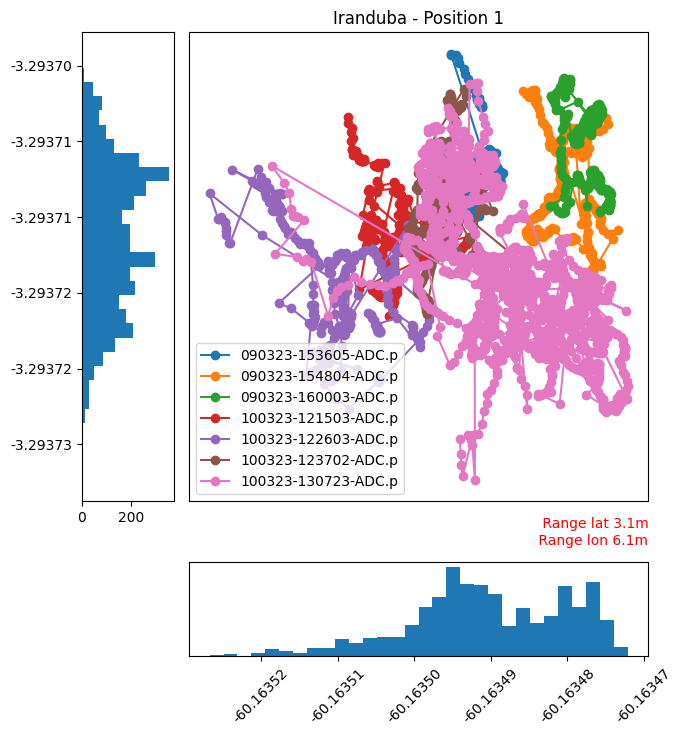

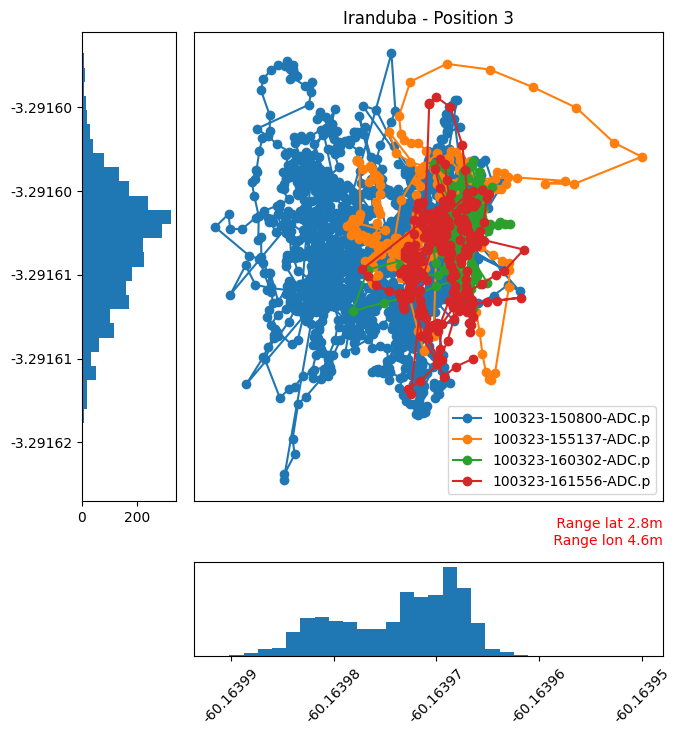

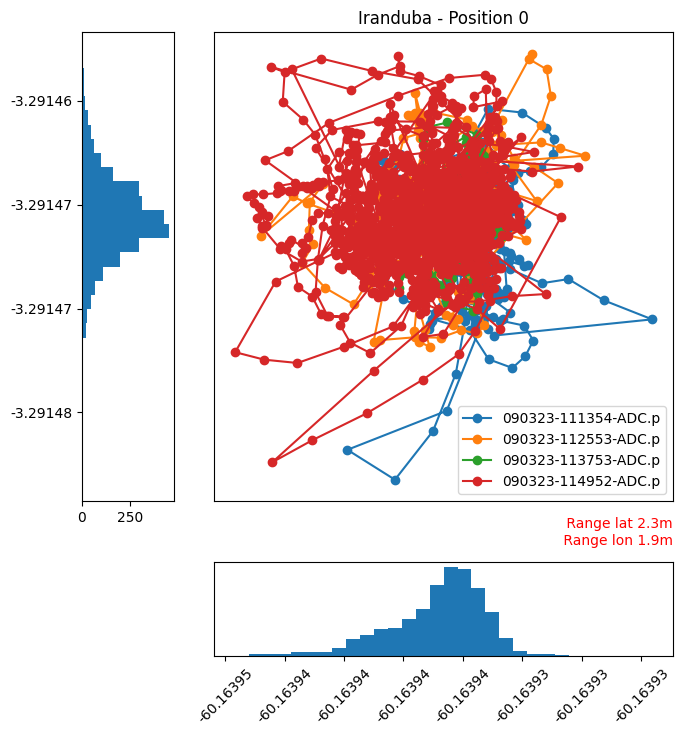

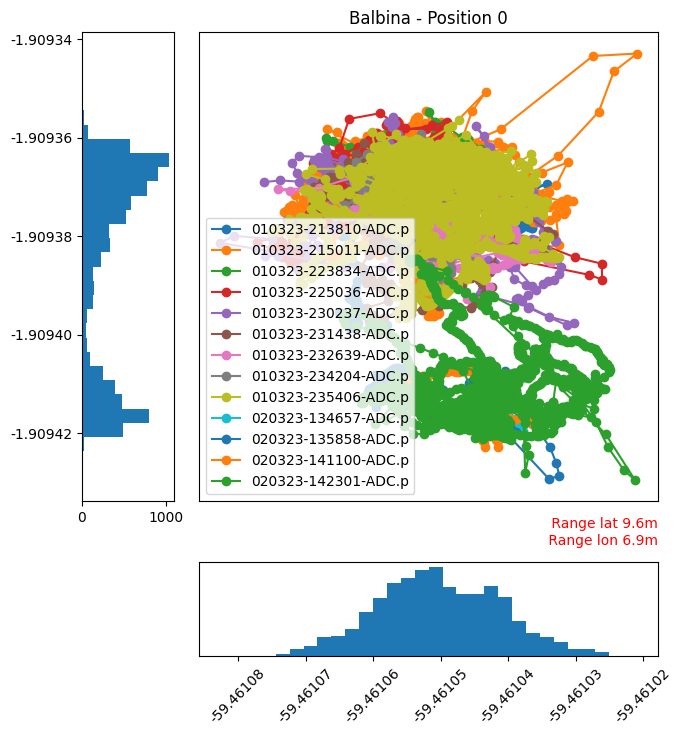

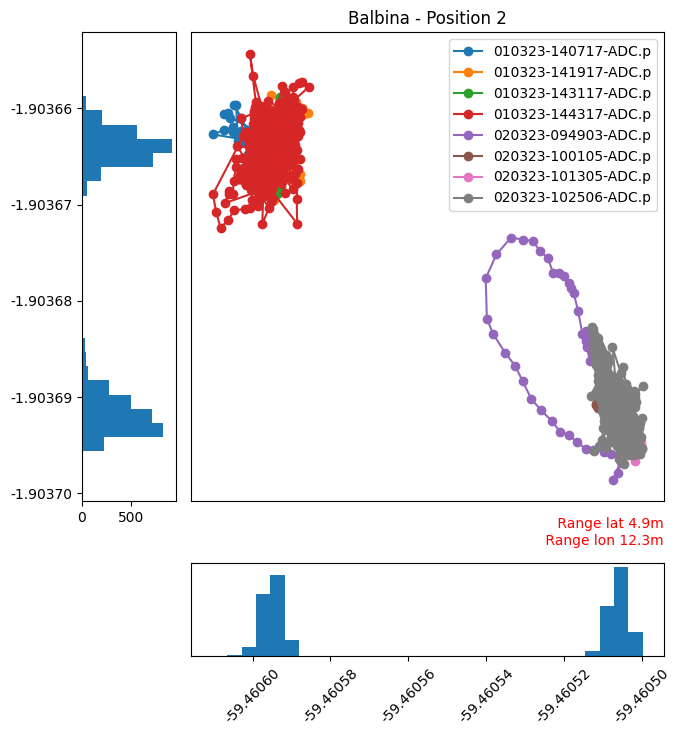

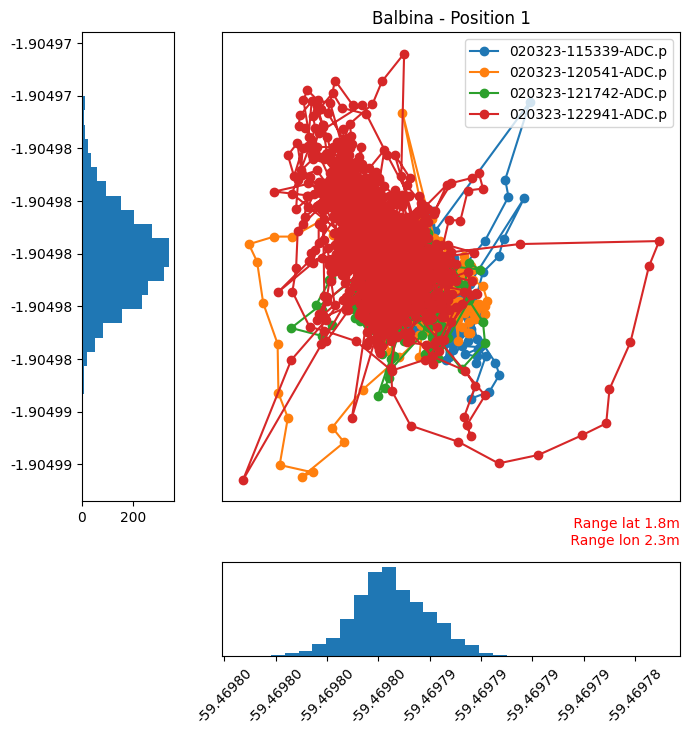

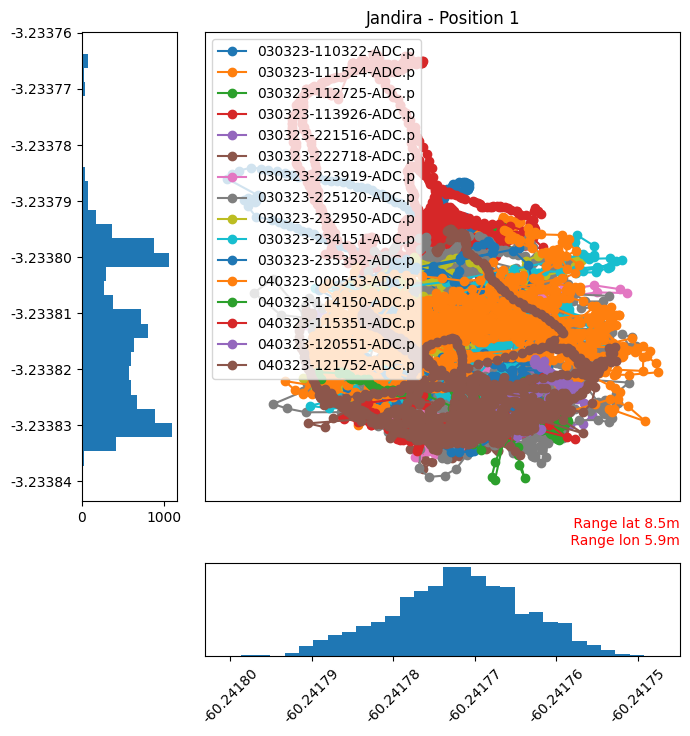

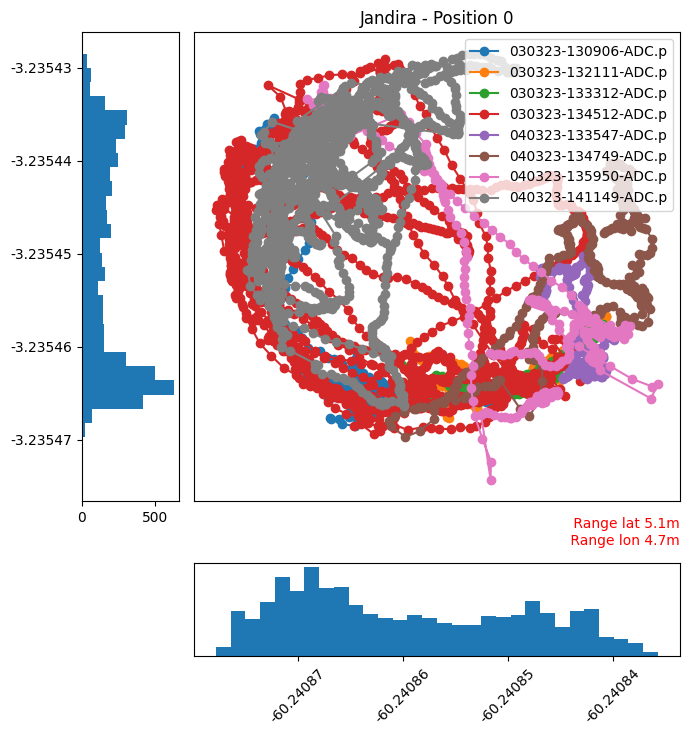

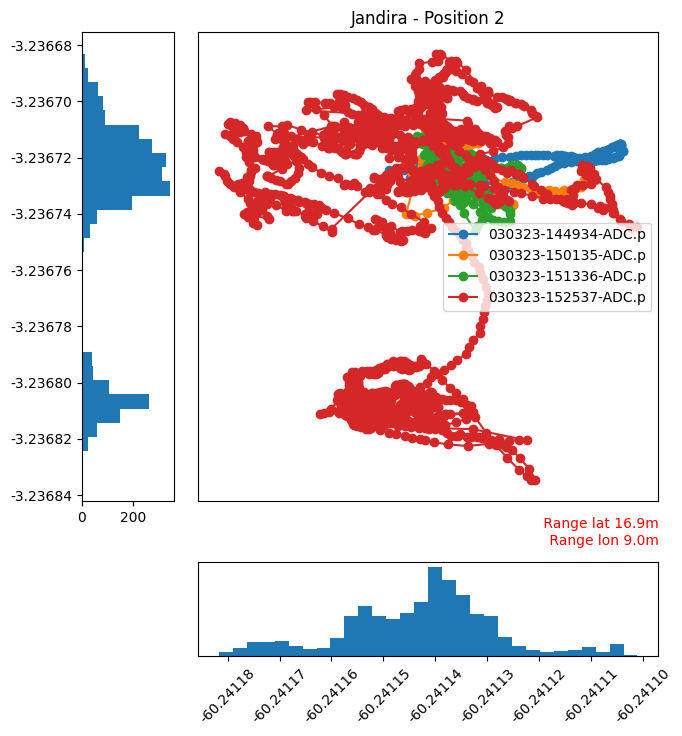

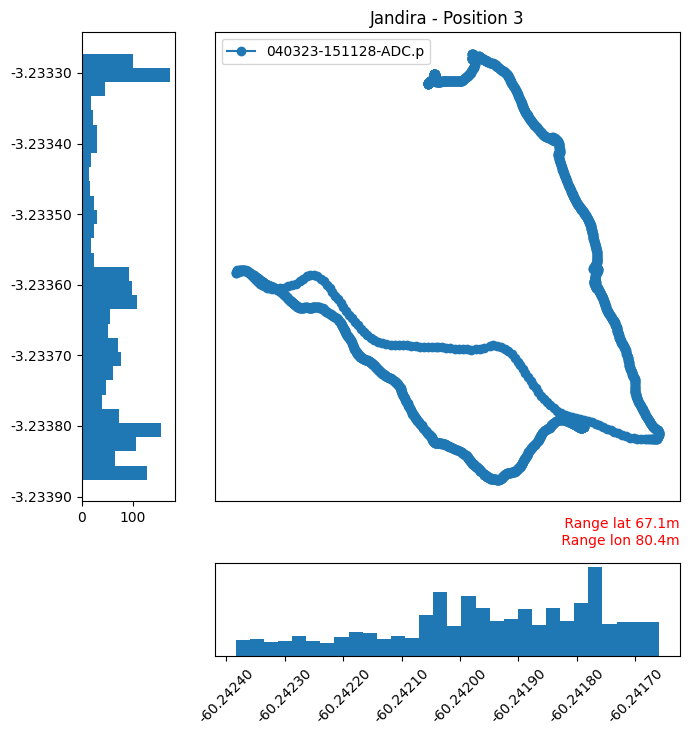

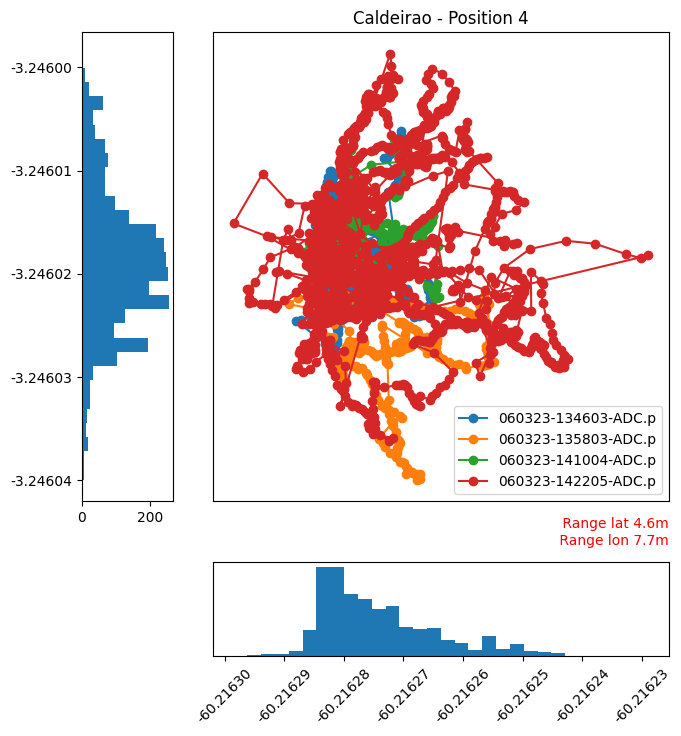

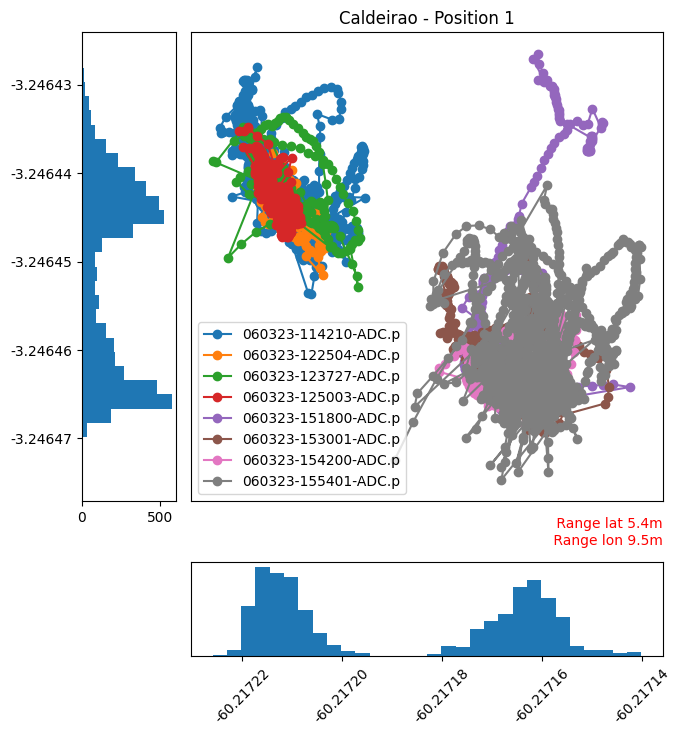

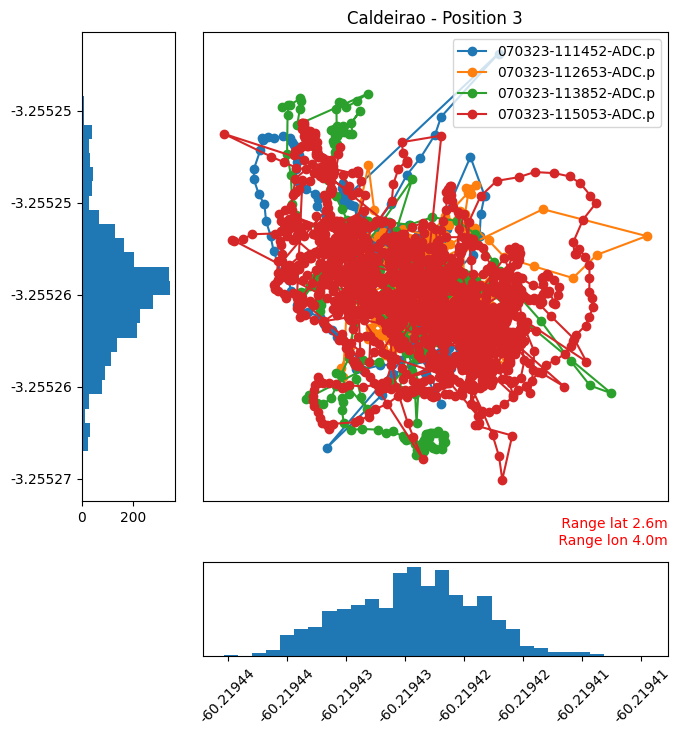

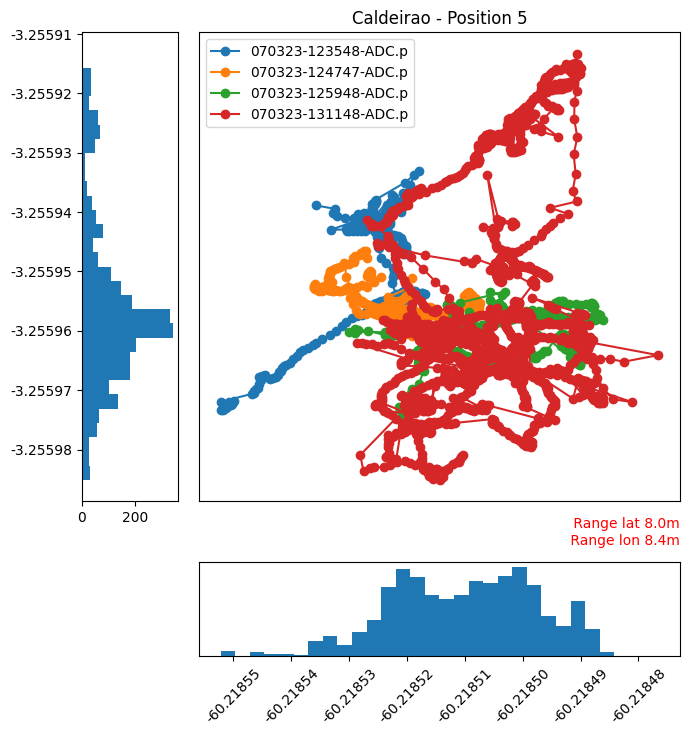

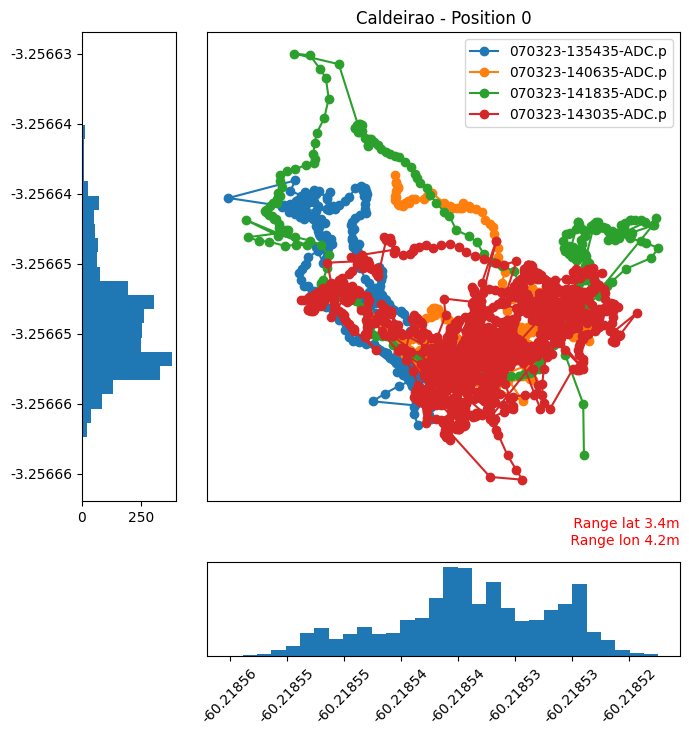

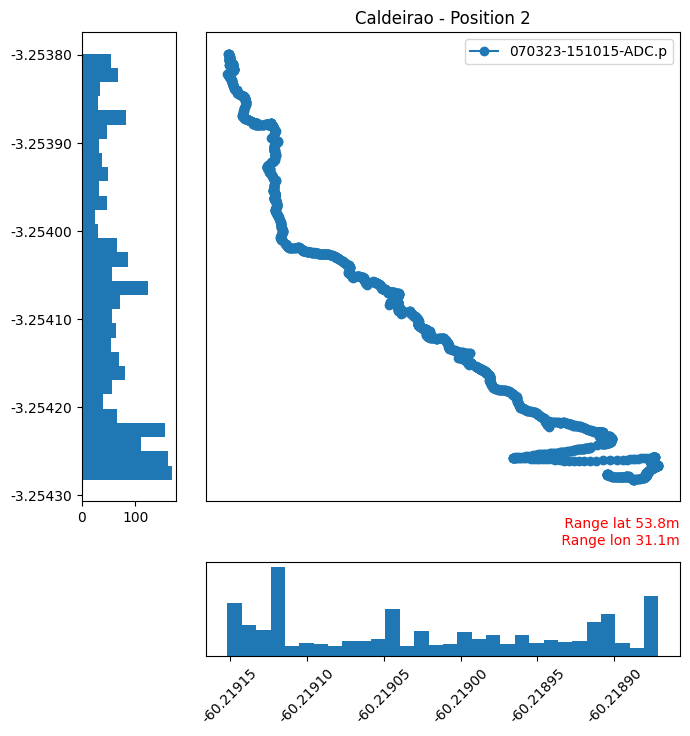

In [16]:
for location_name in df_results.experiment_location.unique():
    df_sep_pos = df_results[(df_results.experiment_location == location_name) &
                            (df_results.meas_running)]
    print(df_sep_pos.shape)

    for index, entry in enumerate(df_sep_pos.position.unique()):
        fig, ax = plt.subplots(figsize=(7, 7))
        gs = gridspec.GridSpec(2, 2,
                            width_ratios=[1, 5],
                            height_ratios=[5, 1])

        ax_vertical_hist = plt.subplot(gs[0])
        ax_main_plot = plt.subplot(gs[1])
        ax_horizontal_hist = plt.subplot(gs[3])

        measurement = df_sep_pos[df_sep_pos.position == entry]
        lat = measurement.lat_est
        lon = measurement.lon_est

        max_long = measurement.lon_est.max()
        min_long = measurement.lon_est.min()
        max_lat = measurement.lat_est.max()
        min_lat = measurement.lat_est.min()
                                # (lat, lon)
        dist_long = hs.haversine((max_lat, min_long),
                                (max_lat, max_long),
                                unit=Unit.METERS)
        dist_lat  = hs.haversine((max_lat, min_long),
                                (min_lat, min_long),
                                unit=Unit.METERS)
        
        ax_vertical_hist.hist(lat, orientation='horizontal', bins=30)
        ax_horizontal_hist.hist(lon, bins=30)
        ax_vertical_hist.yaxis.set_major_formatter(FormatStrFormatter('% .5f'))
        ax_horizontal_hist.yaxis.set_major_formatter(FormatStrFormatter('% .5f'))
        ax_horizontal_hist.xaxis.set_major_formatter(FormatStrFormatter('% .5f'))
        ax_horizontal_hist.get_yaxis().set_visible(False)

        groups = measurement.groupby('corresponding_meas_file')
        for name, group in groups:
            ax_main_plot.plot(group.lon_est, group.lat_est, marker='o', linestyle='-', ms=6, label=name)
            ax_main_plot.legend()
        
        ax_main_plot.set_title(f"{location_name} - Position {int(entry)}")
        #ax_main_plot.axis('equal')
        #ax_main_plot.set_axis_off()
        
        ax_main_plot.get_xaxis().set_visible(False)
        ax_main_plot.get_yaxis().set_visible(False)
        ax_main_plot.annotate(f"\n Range lat {abs(dist_lat):.1f}m\n Range lon {abs(dist_long):.1f}m", 
                        xy=(1, 0),xycoords='axes fraction', fontsize=10,
                        color = 'red',
                        horizontalalignment='right', verticalalignment='top')

        plt.tight_layout()
        plt.xticks(rotation = 45)
        filename = f"{location_name}_Positions_{int(entry)}"
        result_file = output_image_folder / Path(filename+".png") 
        plt.savefig(result_file)